In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp
from jax import random

import sys
sys.path.append('wl-mechanics')
import datasets
from models import utils as mutils
from models import mlp
import train_utils as tutils
from flax.training import checkpoints

2023-09-15 16:39:57.196363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.3/lib64:/pkgs/nccl_2.9.9-1+cuda11.3_x86_64:/pkgs/nccl_2.8.3-1+cuda11.0_x86_64/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib
2023-09-15 16:39:57.196849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.3/lib64:/pkgs/nccl_2.9.9-1+cuda11.3_x86_64:/pkgs/nccl_2.8.3-1+cuda11.0_x86_64/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib
2023-09-15 16:39:57.196861: W tensor

In [3]:
from configs import toy_sb as config
config = config.get_config()
key = random.PRNGKey(config.seed)
key, init_key = random.split(key)
X = datasets.get_toy_data(config, init_key)

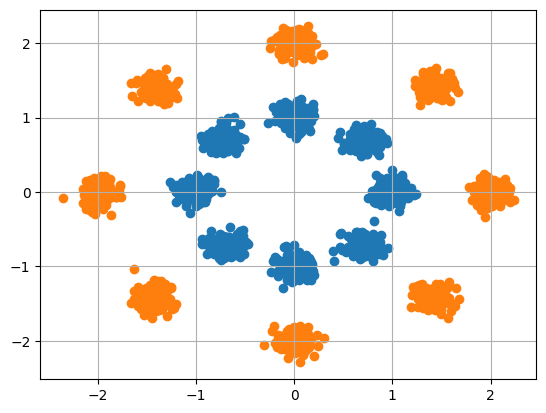

In [4]:
plt.scatter(X[0][:,0], X[0][:,1])
plt.scatter(X[1][:,0], X[1][:,1])
plt.grid()

In [33]:
# chkpt_id = 10689955 # without ind
# chkpt_id = 10689936 # with ind
# chkpt_id = 10691899 # sb
chkpt_id = 10693436 # ubot
chkpt_id = 10696616 # phot

chkpt_id = 10698790 # phot +
chkpt_id = 10699098 # phot -

In [34]:
checkpoint_dir = f'wl-mechanics/checkpoint/{chkpt_id}/checkpoints'

key, *init_key = random.split(key, 3)
model_s, _, initial_params = mutils.init_model_s(init_key[0], config.model_s)
optimizer_s = tutils.get_optimizer(config.optimizer_s)
opt_state_s = optimizer_s.init(initial_params)
time_sampler, init_sampler_state = tutils.get_time_sampler(config)

state_s = mutils.State(step=1, opt_state=opt_state_s,
                      model_params=initial_params,
                      ema_rate=config.model_s.ema_rate,
                      params_ema=initial_params,
                      sampler_state=init_sampler_state,
                      key=key, wandbid=np.random.randint(int(1e7),int(1e8)))
state_s = checkpoints.restore_checkpoint(checkpoint_dir, state_s, prefix='chkpt_s_')

In [35]:
def grad_vf(t,y,state):
  s = mutils.get_model_fn(model_s, 
                          state.params_ema if config.eval.use_ema else state.model_params, 
                          train=False)
  dsdx = jax.grad(lambda _t, _x: s(_t*jnp.ones((_x.shape[0],1)), _x).sum(), argnums=1)
  return dsdx(t,y)

def grad_vf_weighted(t,y,state):
      y, w = y
      s = mutils.get_model_fn(model_s, 
                              state.params_ema if config.eval.use_ema else state.model_params, 
                              train=False)
      dsdx = jax.grad(lambda _t, _x: s(_t, _x).sum(), argnums=1)
      return (dsdx(t*jnp.ones((y.shape[0],1)),y), s(t*jnp.ones((y.shape[0],1)), y))

In [36]:
dt = 1e-2
n = int(1/dt)
solution = np.zeros((X[0].shape[0],n+1,2))
solution[:,0,:] = X[0]
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(100):
  eps = random.normal(random.fold_in(loop_key, i), shape=(X[0].shape[0], 2))
  solution[:,i+1,:] = solution[:,i,:] + dt*grad_vf(t[i], solution[:,i,:], state_s)
  t[i+1] = t[i] + dt

In [31]:
dt = 1e-2
n = int(1/dt)
solution = np.zeros((X[0].shape[0],n+1,2))
solution[:,0,:] = X[0]
logw = np.zeros((X[0].shape[0],n+1,1))
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(100):
  eps = random.normal(random.fold_in(loop_key, i), shape=(X[0].shape[0], 2))
  dxdt, dlogwdt = grad_vf_weighted(t[i], (solution[:,i,:], logw[:,i,:]), state_s)
  solution[:,i+1,:] = solution[:,i,:] + dt*dxdt
  logw[:,i+1,:] = logw[:,i,:] + dt*dlogwdt
  t[i+1] = t[i] + dt
w = jnp.exp(logw[:,:,0] - jax.scipy.special.logsumexp(logw[:,:,0], axis=0, keepdims=True))

In [22]:
dt = 1e-2
n = int(1/dt)
solution = np.zeros((X[0].shape[0],n+1,2))
solution[:,0,:] = X[0]
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(100):
  eps = random.normal(random.fold_in(loop_key, i), shape=(X[0].shape[0], 2))
  solution[:,i+1,:] = solution[:,i,:] + dt*grad_vf(t[i], solution[:,i,:], state_s) + jnp.sqrt(dt)*config.sigma*eps
  t[i+1] = t[i] + dt

In [12]:
from matplotlib.collections import LineCollection

n = 300
w_normed = w/w.max()
figsize(6,6)
plt.scatter(solution[:n,0,0], solution[:n,0,1], alpha=1.0)
plt.scatter(solution[:n,-1,0], solution[:n,-1,1], alpha=w_normed[:,-1])
for i in range(n):
  points = solution[i,::4,:].reshape(-1,1,2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  lc = LineCollection(segments, cmap=plt.get_cmap('Blues'), norm=plt.Normalize(0, 1), alpha=0.3)
  lc.set_array(w_normed[i,::4])
  plt.gca().add_collection(lc)
plt.xticks(range(-2,3), [])
plt.yticks(range(-2,3), [])
plt.grid()
# plt.savefig('wl-mechanics/assets/sb.pdf', bbox_inches='tight')

NameError: name 'w' is not defined

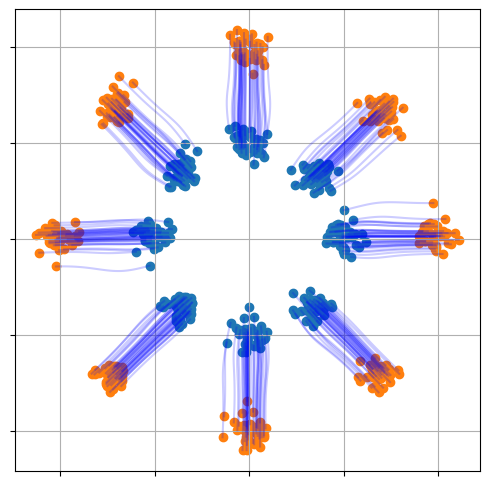

In [37]:
n = 300
figsize(6,6)
plt.scatter(solution[:n,0,0], solution[:n,0,1])
plt.scatter(solution[:n,-1,0], solution[:n,-1,1])
for i in range(n):
  plt.plot(solution[i,:,0], solution[i,:,1], c='blue', alpha=0.2)
plt.xticks(range(-2,3), [])
plt.yticks(range(-2,3), [])
plt.grid()
# plt.savefig('wl-mechanics/assets/phot.pdf', bbox_inches='tight')